# Modelado en Series de Tiempo

## Importación de librerias necesarias

In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.cm as cm
from datetime import datetime
from pandas.plotting import lag_plot

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.simplefilter('ignore')

In [2]:
def seasonal_decompose(df,column,model, period):
    
    res = sm.tsa.seasonal_decompose(
        df[column], model=model, period=period
        )
    
    fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(12, 18))
    
    ax1.set_title('Comportamiento del universo')
    df[column].plot(ax=ax1, color='red')
    ax1.ticklabel_format(style='plain', axis='y')#para sacar la notacion cientifica, sino comentar
    ax1.set_ylabel('Original')
    
    res.trend.plot(ax=ax2)
    ax2.set_title('Tendencia')
    ax2.ticklabel_format(style='plain', axis='y')#para sacar la notacion cientifica, sino comentar
    ax2.set_ylabel('Tendencia')
    
    res.seasonal.plot(ax=ax3)
    ax3.set_title('Variaciones Estacionales')
    ax3.ticklabel_format(style='plain', axis='y')#para sacar la notacion cientifica, sino comentar
    ax3.set_ylabel('Variaciones Estacionales')
    
    res.resid.plot(ax=ax4)
    ax4.set_title('Variaciones Irregulares')
    ax4.ticklabel_format(style='plain', axis='y')#para sacar la notacion cientifica, sino comentar
    ax4.set_ylabel('Variaciones Irregulares')
    
    plt.tight_layout()
    plt.show()

In [3]:
def plot_sarimax_test(test_set: pd.DataFrame, predictions: pd.Series) -> None:
    """
    This function plots the train set and  the forecast.
    ---
    Args:
        test_set (pd.DataFrame):  test set dataframe
        predictions (pd.Series):  forecast values as series
        
    Returns: None
    """
    # Figure
    fig, ax = plt.subplots(figsize=(16,9), facecolor='w')

    ax.plot(test_set['numero_licencia'], label='Testing Set')
    ax.plot(predictions, label='Forecast')

    # Labels
    ax.set_title("Test vs Predicho", fontsize=15, pad=15)
    ax.set_ylabel("Number of orders", fontsize=12)
    ax.set_xlabel("Date", fontsize=12)
    
    # Legend & Grid
    ax.grid(linestyle=":", color='grey')
    ax.legend()
    
    plt.show()

Cargamos la base de datos de licencias médicas

In [4]:
url = 'https://raw.githubusercontent.com/MentoriaDiploDatos/Presentacion/main/data.csv'
df = pd.read_csv(url, sep=';')
df.head(3)

,numero_licencia,fecha_creacion,dispositivo_acceso,dias_solicitados,fecha_inicio,fecha_fin,diagnostico,id_diagnostico,id_usuario,fecha_nacimiento,genero,tipo_licencia,estado_civil,dias_aprobados,decision_medica,id_auditor,motivo_rechazo,categoria_diagnostico
0,1,2021-01-01 00:10:10.418,APP,2.0,2021-01-01,2021-01-01,EFECTOS ADVERSOS DE VACUNAS VIRALES,NaN,15508,1979-11-28,FEMALE,Médica,OTHER,2.0,EDITAR_Y_APROBAR,14721.0,NaN,NaN
1,105,2021-01-02 14:14:20.330,APP,2.0,2021-01-02,2021-01-03,EFECTOS ADVERSOS DE VACUNAS VIRALES,NaN,15508,1979-11-08,FEMALE,Médica,OTHER,2.0,EDITAR_Y_APROBAR,14721.0,NaN,NaN
2,113806,2021-08-26 09:32:09.396,APP,1.0,2021-08-26,2021-08-26,COLELITIASIS,NaN,3661,1980-10-25,FEMALE,Médica,SINGLE,0.0,RECHAZAR,14721.0,NaN,NaN


## Creando la base de datos con la cual se va a modelar

Para el ejemplo vamos a trabajar con todas las licencias médicas.
Asignamos el tipo de dato _datetime_ a `fecha_creacion`

In [5]:
df['fecha_creacion'] = pd.to_datetime(df['fecha_creacion']).dt.date
df['fecha_creacion'] = df['fecha_creacion'].apply(lambda x: pd.to_datetime(x, format='%Y/%m/%d'))

Se realiza un _resample_ semanal

In [6]:
df["datetime_monday_week"] = df["fecha_creacion"].dt.to_period('W').dt.start_time

In [7]:
df.set_index('fecha_creacion', inplace=True)

In [8]:
df_week= df.groupby("datetime_monday_week").count().reset_index()

A continuación se muestra la variación de las licencias agrupadas semanalmente a lo largo del período 2021-2022

<AxesSubplot:>

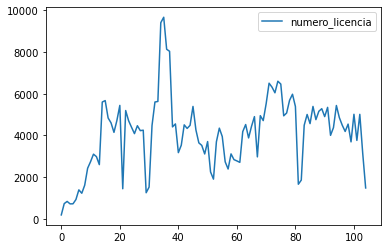

In [9]:
df_week[['numero_licencia']].plot()

In [10]:
df_week.set_index("datetime_monday_week", inplace=True)

## Descomposición de la serie temporal

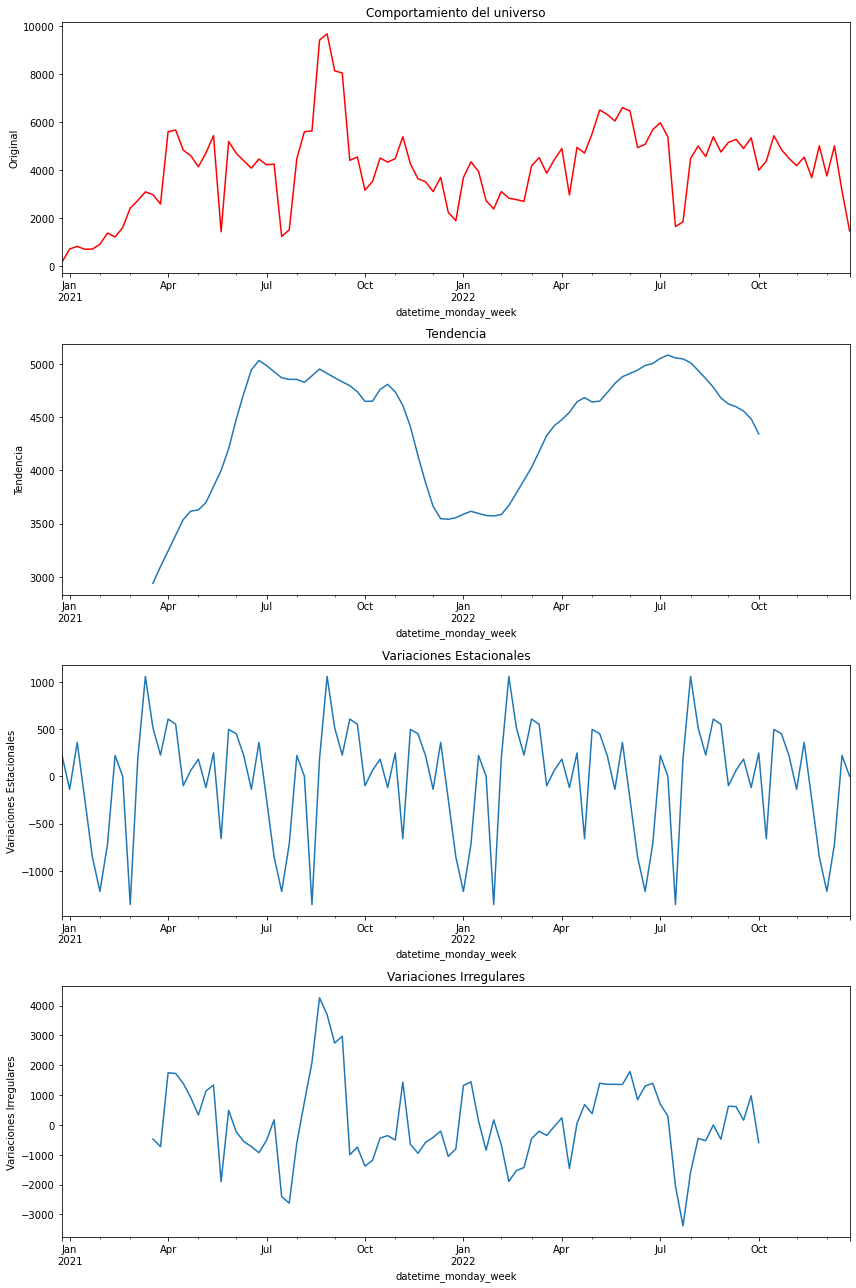

In [11]:
seasonal_decompose(df_week,
                   'numero_licencia', 
                   model='additive',
                   period=24)

In [12]:
df_ = df_week.groupby("datetime_monday_week")[['numero_licencia']].sum()

In [13]:
df_

,numero_licencia
datetime_monday_week,
2020-12-28,183
2021-01-04,725
2021-01-11,830
2021-01-18,713
2021-01-25,716
...,...
2022-11-28,5010
2022-12-05,3757
2022-12-12,5007


## Dickey Fuller Test

Ho Serie no estacionaria

Ha Serie estacionaria

In [119]:
r_df = adfuller(df_['numero_licencia'])
print('test statistics ->', r_df[0])
print('p value ->', r_df[1])

test statistics -> -4.078089769499095
p value -> 0.0010525188669166833


## ACF y PACF

**Autocorrelation Function (ACF)** = autocorrelación entre la serie de tiempo y una retrasada de si misma ---> Moving Average Model (MA)

Proceso de promedio móvil (MA), un proceso en el que el valor actual de la serie se define como una combinación lineal de errores pasados. Suponemos que los errores se distribuyen independientemente con la distribución normal. 

ACF define el orden MA(q)

**Partial Autocorrelation Function** = La autocorrelación parcial mide la correlación entre dos variables separadas por k periodos cuando no seconsidera la dependencia creada por los retardos intermedios existentes entre ambas.

Proceso autorregresivo (AR) , se dice que una serie de tiempo es AR cuando el valor presente de la serie de tiempo se puede obtener utilizando valores anteriores de la misma serie de tiempo, es decir, el valor presente es el promedio ponderado de sus valores pasados. 

PACF define AR (p)

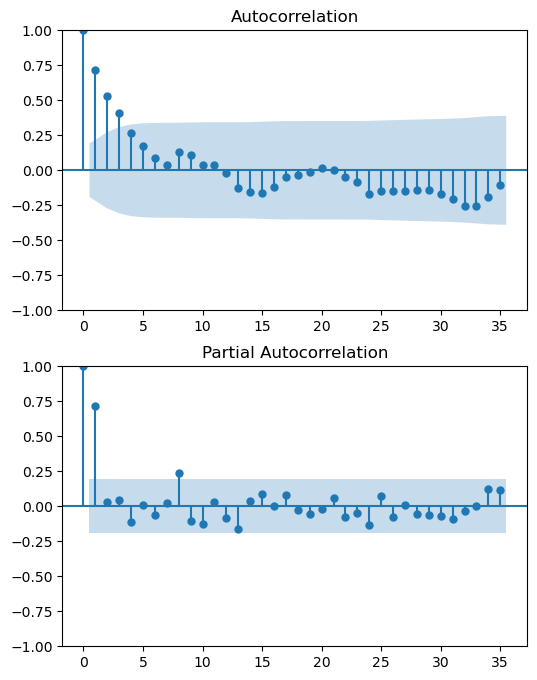

In [26]:
fig, axes = plt.subplots(2,1,figsize=(6,8))

plot_acf(df_, lags=35,ax=axes[0]);
plot_pacf(df_, lags=35,ax=axes[1]);

## Modelando ARIMA Seasonal o SARIMA

\begin{align*}
\LARGE \mathbf{ARIMA} (p, d, q) {x} (P, D, Q)S
\end{align*}

Elementos de la tendencia:

- p: orden autoregresivo
- d: orden de la diferenciación (_differencing_)
- q: orden de la media móvil
    
Elementos de la estacionalidad:

- P: orden autoregresivo estacional.
- D:orden de la diferenciación estacional. D=1 calcula el primer orden de la diferencia estacional
- Q: orden de la media móvil estacional. Q=1 usa errores de primer orden en el modelo
- S: Período estacional único

In [81]:
auto_arima(df_,
           start_p=0, 
           start_q=0,
           d=1,
           max_d=3,
           max_p=4, 
           max_q=4, 
           seasonal=True, 
           trace=1, 
           m=24).summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=1781.518, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=1781.533, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=1779.826, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=1779.097, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=1779.548, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=1780.446, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=1781.263, Time=0.13 sec
 ARIMA(0,1,1)(0,0,2)[24] intercept   : AIC=1781.323, Time=0.25 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=1779.290, Time=0.06 sec
 ARIMA(0,1,1)(1,0,2)[24] intercept   : AIC=inf, Time=1.33 sec
 ARIMA(0,1,0)(0,0,1)[24] intercept   : AIC=1780.099, Time=0.06 sec
 ARIMA(1,1,1)(0,0,1)[24] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,2)(0,0,1)[24] intercept   : AIC=1778.571, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[24] intercept   : AIC=1780.083, Time=0.07 sec
 ARIMA(0,1,2)(1,0,1)[24] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 24)   Log Likelihood                -882.782
Date:                             Thu, 10 Aug 2023   AIC                           1773.564
Time:                                     15:49:46   BIC                           1784.141
Sample:                                 12-28-2020   HQIC                          1777.849
                                      - 12-26-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7431      0.100      7.464      0.000       0.548       0.938
ma.L1         -0.9514      0.061    -15.610      0.000      -1.071      -0.832
ar.S.L24      -0.2208      0.129     -1.715      0.086      -0.473       0.032
sigma2      1.355e+06   1.22e+05     11.097      0.000    1.12e+06    1.59e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                41.70
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -0.09
Prob(H) (two-sided):                  0.05   Kurtosis:                         6.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
len(df_)

105

In [14]:
train_data  = df_.iloc[0:75]

In [15]:
test_data = df_.iloc[75:]

In [16]:
order = (1,1,1)
seasonal_order= (1,0,0,24)
start=len(train_data)
end=len(train_data)+len(test_data)-1

results = SARIMAX(train_data,
                  order=order,
                  seasonal_order=seasonal_order).fit()
predictions_sarima = results.predict(start=start, 
                                     end=end,
                                     dynamic=False, 
                                     typ='levels').rename('SARIMA {}{} Predictions'.format(order,seasonal_order))

In [17]:
print("Error absoluto medio: {}".format(mean_absolute_error(test_data, predictions_sarima)))
print("Error cuadrático medio: {}".format(np.sqrt(mean_squared_error(test_data, predictions_sarima))))

Error absoluto medio: 922.0596781981541
Error cuadrático medio: 1426.6427989041554


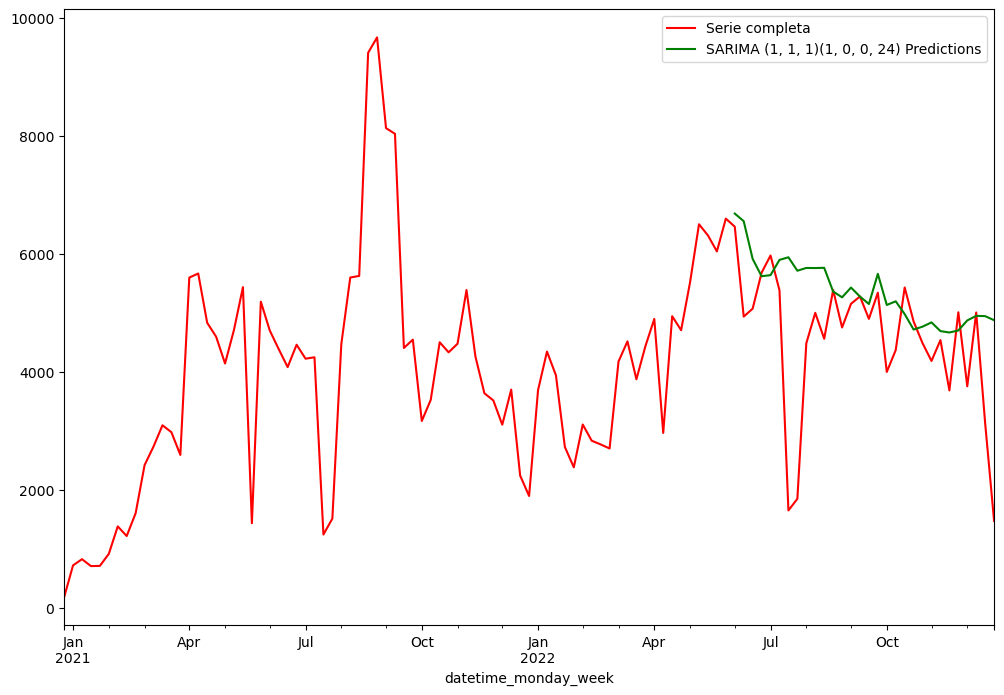

In [84]:
df_.numero_licencia.plot(legend=True, 
                              label='Serie completa', 
                              color='red',
                              figsize=(12,8)).ticklabel_format(style='plain', axis='y')

predictions_sarima.plot(legend=True,
                        color='green', 
                        figsize=(12,8))
plt.show()

### Viendo en detalle test y lo predicho

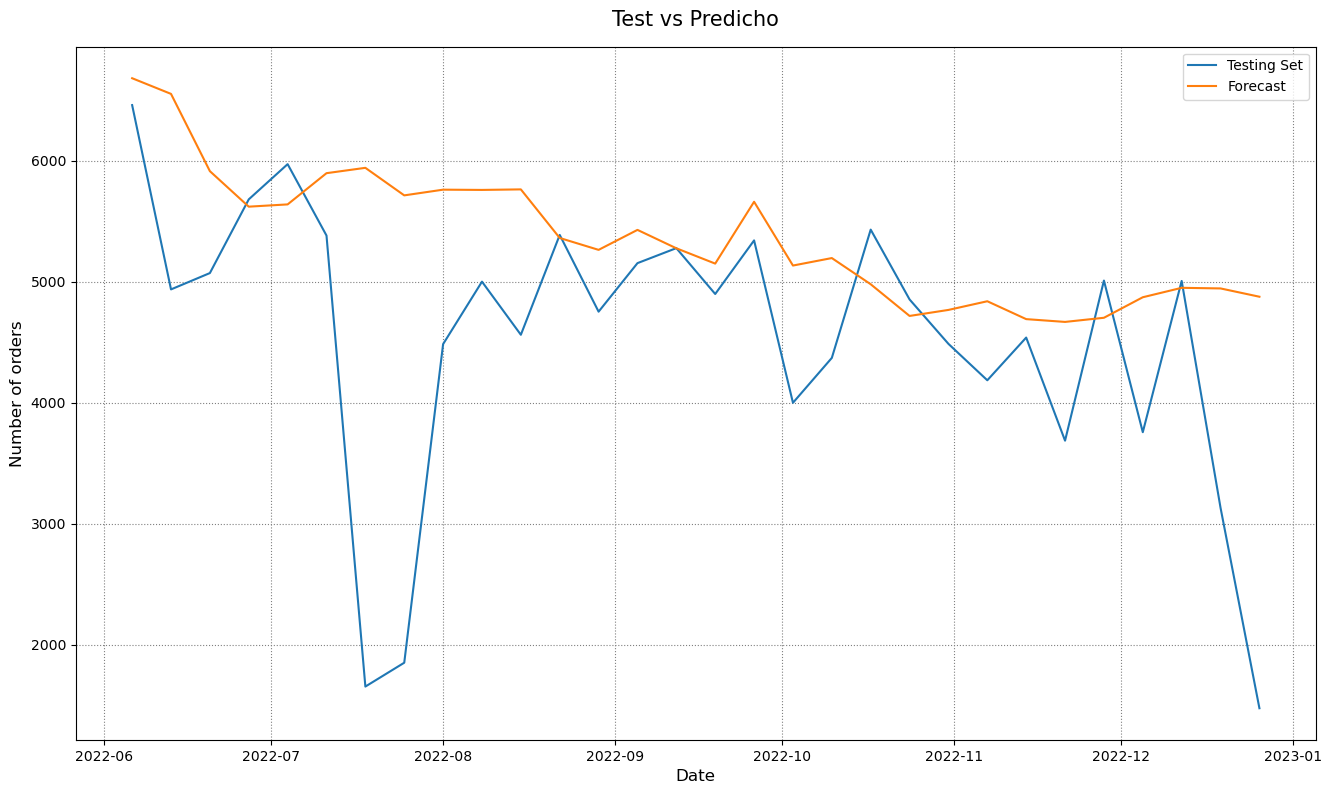

In [150]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

predictions = results.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data['numero_licencia'] - predictions

plot_sarimax_test(test_data, predictions)

- **The standardize residual plot**: Los residuos no muestran un patrón claro. Ruido
- **The Normal Q-Q-plot**: Desviación de los residuos de la normalidad.
- **Histogram and estimated density plot**: Se confirma que los residuos no siguen una distribución normal
- **The Correlogram plot**: Muestra que los residuos de la serie temporal tienen una baja correlación con las versiones retrasadas de sí mismos (en general). 

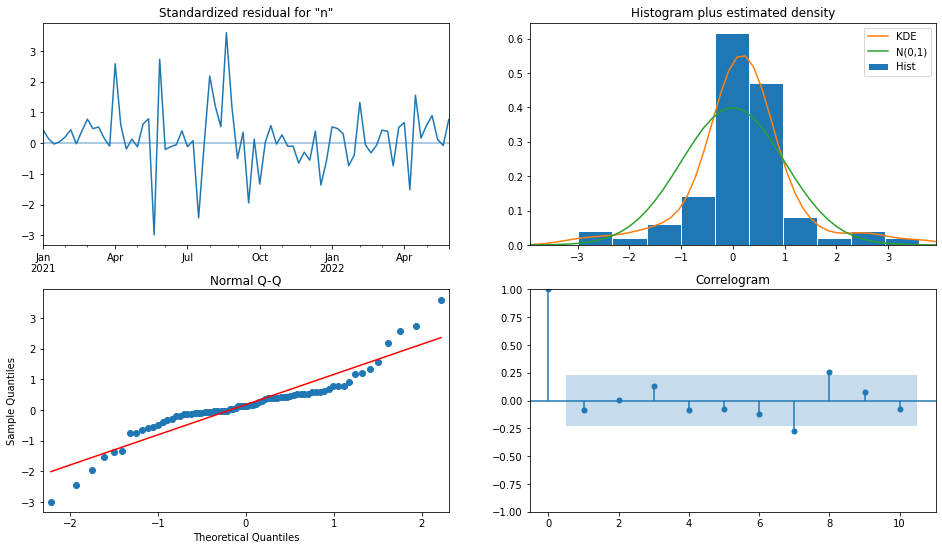

In [19]:
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(16, 9))
plt.show()

## Graficando resultados del modelo para toda la serie

In [138]:
# generando las predicciones
results_all = SARIMAX(df_,
                  order=order,
                  seasonal_order=seasonal_order).fit()

one_step_forecast = results_all.get_prediction()

# media de las predicciones
mean_forecast = one_step_forecast.predicted_mean

# intervalo de confianza para las predicciones
confidence_intervals = one_step_forecast.conf_int()

# limites superior e inferior
lower_limits = confidence_intervals.loc[:,'lower numero_licencia']
upper_limits = confidence_intervals.loc[:,'upper numero_licencia']

print(mean_forecast)

2020-12-28       0.000000
2021-01-04     169.139957
2021-01-11     641.087832
2021-01-18     740.419394
2021-01-25     650.675611
                 ...     
2022-11-28    4121.917094
2022-12-05    4868.404879
2022-12-12    3770.996219
2022-12-19    4795.561574
2022-12-26    3499.531803
Freq: W-MON, Name: predicted_mean, Length: 105, dtype: float64


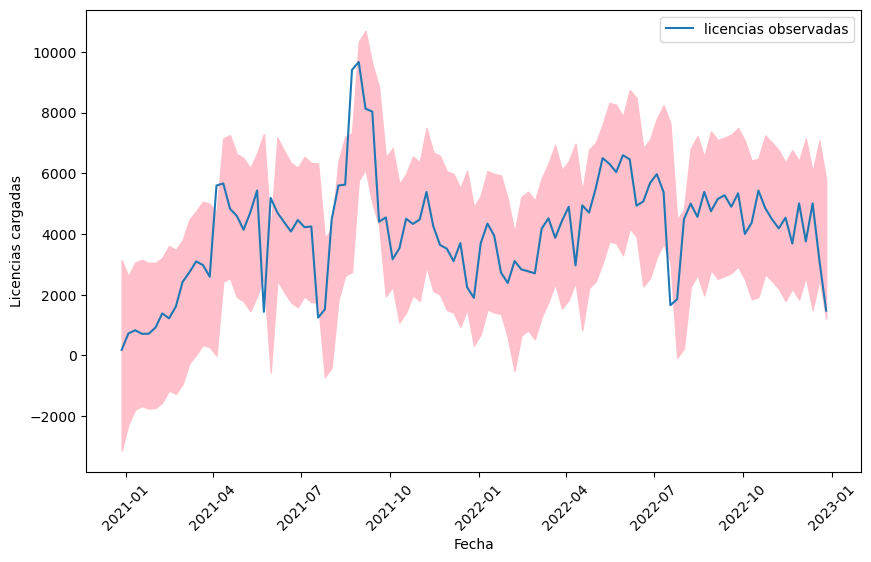

In [142]:
plt.figure(figsize=(10,6))
plt.fill_between(confidence_intervals.index, lower_limits, upper_limits, color='pink')
plt.plot(df_.index, df_.numero_licencia, label='licencias observadas')
plt.xlabel('Fecha')
plt.ylabel('Licencias cargadas')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## Exponential Smoothing

In [20]:
#Holt Winter’s Exponential Smoothing

trend='add'
seasonal='mul'
seasonal_periods=24

model = ExponentialSmoothing(train_data,
                             trend=trend,#se especifica la tendencia
                             damped_trend=True,#tendencia amortiguada
                             seasonal=seasonal, #tipo de estacionalidad
                             seasonal_periods=seasonal_periods,#numero de periodos de un ciclo estacional
                             initialization_method="estimated").fit()
exponential_predictions = model.forecast(len(test_data)).rename('Exponential Smoothing Predictions')

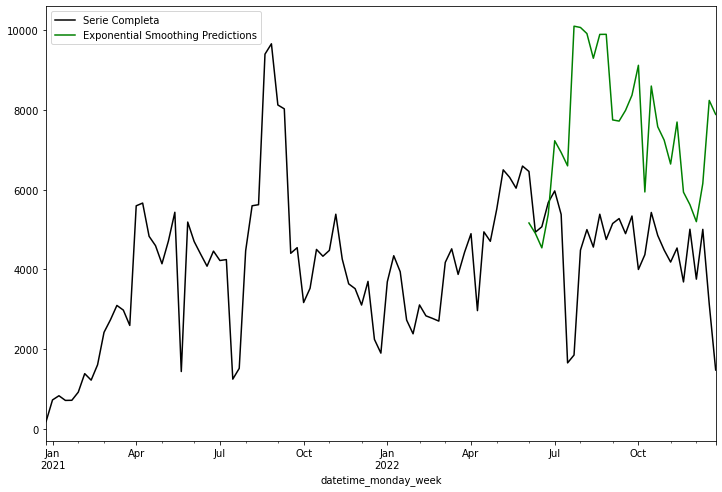

In [21]:
df_.numero_licencia.plot(legend=True, 
                              label='Serie Completa', 
                              color='black',
                              figsize=(12,8)).ticklabel_format(style='plain', axis='y')

exponential_predictions.plot(legend=True, 
                             color='green',
                             figsize=(12,8))
plt.show()

In [22]:
print("Error absoluto medio: {}".format(mean_absolute_error(test_data, exponential_predictions)))
print("Error cuadrático medio: {}".format(np.sqrt(mean_squared_error(test_data, exponential_predictions))))

Error absoluto medio: 3074.2128271131833
Error cuadrático medio: 3656.4853482570134


## Pronósticos

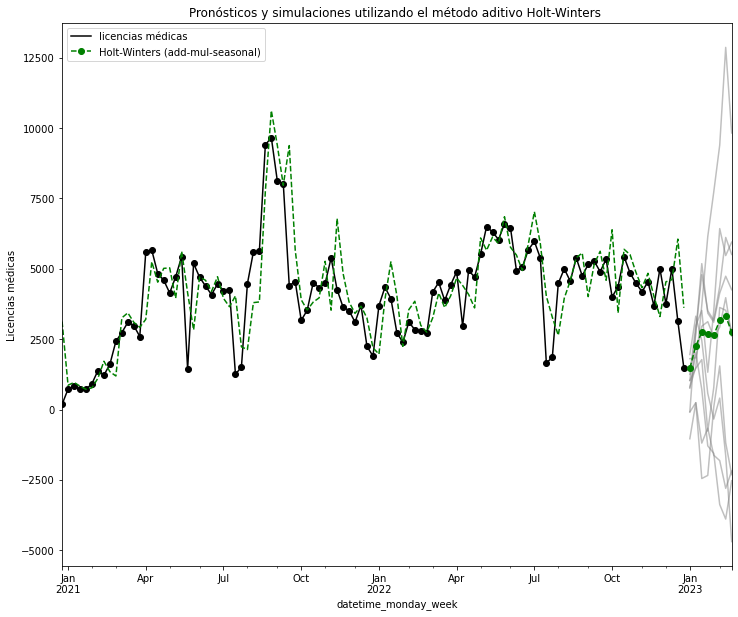

In [25]:
model_total = ExponentialSmoothing(
    df_,
    seasonal_periods=24,
    trend="add",
    seasonal="mul",
    initialization_method="estimated",
    
).fit()

simulations = model_total.simulate(8, 
                             repetitions=10, 
                             error="add",
                             random_state=15)

ax = df_.plot(
    figsize=(12, 10),
    marker="o",
    color="black",
    title="Pronósticos y simulaciones utilizando el método aditivo Holt-Winters ",
    legend=False
)
ax.set_ylabel("Licencias médicas")
ax.legend(["licencias médicas"])

model_total.fittedvalues.plot(ax=ax, 
                        style="--", 
                        color="green")
simulations.plot(ax=ax, 
                 style="-",
                 alpha=0.5, 
                 color="grey", 
                 legend=False)

model_total.forecast(8).rename("Holt-Winters (add-mul-seasonal)").plot(ax=ax, 
                                                               style="--", 
                                                               marker="o", 
                                                               color="green", 
                                                               legend=True)
plt.show()